<a href="https://colab.research.google.com/github/AnIsAsPe/ClassificadorCancerEsofago/blob/master/Notebooks/Selecci%C3%B3n_de_casos_de_an%C3%A1lisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Selección de casos de análisis

El conjunto de entrenamiento está formado por 94,446 imagenes adquiridas de 44 pacientes. El archivo TrainingSet_20aimVO.csv contiene el nombre de cada una de las imagenes y la clase a la que pertenece.

Las clases contempladas son 4:
0. Squamous epithelium (tejido saludable)
1. Intestinal Metaplasia (tejido del esofajo que se ha transformado en tejido intestinal)
2. Gastric Metaplasia (tejido gastrico cercano a la unión con el esófago)
3. Displasya/Cancer (celulas pre-cancerosas/Cáncer)

Para nuestro clasificador binomial utilizaremos solamente las imagenes de tejido sano y de células pre-cancerígenas o cancerígenas.

El presente Notebook crea un subconjunto de imágenes reducidas a la mitad del tamaño, con los casos que usaremos en el clasificador con Perceptrón.


## Paso 1. Cargar librerías y módulos requerdidos

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage.transform import resize
from skimage.io import imread, imsave

import matplotlib.pyplot as plt
from matplotlib import image

## Paso 2. Lectura de datos.

- imágenes(X)
- etiquetas(Y).

In [ ]:
train_df = pd.read_csv("TrainingSet_20aimVO.csv")

In [ ]:
train_df.head()

,image_filename,class_number
0,im_4_0.png,0
1,im_21_0.png,0
2,im_9_0.png,0
3,im_8_0.png,0
4,im_15_0.png,0


In [ ]:
train_df['class_number'].value_counts(sort=False)

class_number
0    1469
3    3594
1    3177
2    1206
Name: count, dtype: int64

In [ ]:
train_df.head(3)

,image_filename,class_number
0,im_4_0.png,0
1,im_21_0.png,0
2,im_9_0.png,0


### 2.1  Seleccionamos las imagenes de tejido sano y tejido con cancer

In [ ]:
dat = train_df[(train_df.class_number == 0) |(train_df.class_number == 3 )]  #Seleccionamos solamente las imagenes de tejido
                                                                               #sano y tejido con cancer
dat = dat.replace(3,1)   #Renombramos la clase 3 como clase 1

dat.shape

(5063, 2)

In [ ]:
dat.class_number.value_counts(sort=False)

class_number
0    1469
1    3594
Name: count, dtype: int64

In [ ]:
dat.to_csv('Output_DataSet/ClasesImagenes.csv',index=False)

### 2.2  Exploramos el formato de las imagenes mediante un ejemplo

Cuando cargamos una imagen a color, el objeto resultante es una matriz de tres dimensiones, que representa de manera eficiente el nivel de cada pixel entre 0 y 255 (256 niveles discretos de color son suficientes para la percepción del ojo humano)

In [ ]:
image_path = "Extracted_original_images/TrainingSetImagesDir/"
dat['image_filename'] = dat['image_filename'].apply(lambda x: image_path + x)

dat.head()

,image_filename,class_number
0,Extracted_original_images/TrainingSetImagesDir...,0
1,Extracted_original_images/TrainingSetImagesDir...,0
2,Extracted_original_images/TrainingSetImagesDir...,0
3,Extracted_original_images/TrainingSetImagesDir...,0
4,Extracted_original_images/TrainingSetImagesDir...,0


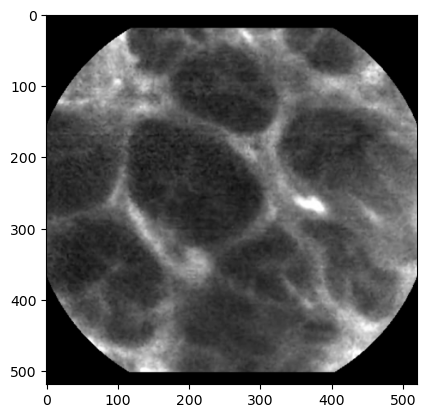

In [ ]:
i = 2693
file = dat.iloc[i] ['image_filename']
imagen_ej = imread(file)
_ = plt.imshow(ejem)

In [ ]:
#Revisamos la dimensión que tiene una sola imagén, en este caso es la primera
ejem.shape

(519, 521, 3)


 «How to Convert a Picture to Numbers». Accedido 12 de mayo de 2020. https://e2eml.school/images_to_numbers.html.

- Dimensión 0: 519 renglones de pixeles de arriba a abajo
- Dimension 1: 521 columnas de pixeles de izquierda a derecha
- Dimension 2: 3 Canales de color (rojo, verde y azul en ese orden) (RGB)

In [ ]:
# Explorando los colores de un pixel cualquiera de la primera imagen.
imagen_ej[240][51]


array([53, 53, 53], dtype=uint8)

Cuando los valores de los tres canales del color RGB son idénticos, se obtiene un tono de gris entre 0 equivalente a negro y 255 equivalente a banco.

In [ ]:
i = 2693
file = dat.iloc[i] ['image_filename']
imagen_ej = imread(file)
n_unique = np.unique(imagen_ej)
print(f"En la imagen {i} hay {len(n_unique)} valores únicos, que van desde el {np.min(n_unique)} hasta el {np.max(n_unique)}")


En la imagen 2693 hay 256 valores únicos, que van desde el 0 hasta el 255


In [ ]:
def scale_grayscale_skimage(image_path, output_size):
    """Scales a 3-channel grayscale image using scikit-image."""
    img = imread(image_path)

    # Check if the image is grayscale (all channels are equal)
    if not np.all(img[:, :, 0] == img[:, :, 1]) or not np.all(img[:, :, 0] == img[:, :, 2]):
        raise ValueError("Image is not grayscale (channels are not equal).")

    # Extract a single grayscale channel
    gray_img = img[:, :, 0]

    # Resize the grayscale image
    scaled_gray = resize(gray_img, output_size, anti_aliasing=True)

    # Convert to uint8 for saving
    scaled_img_uint8 = (scaled_gray * 255).astype('uint8')

    return scaled_img_uint8

### 2.3 Leemos, escalamos y nos quedamos con un solo canal de todas las imágenes de tejido sano y tejido con cáncer



In [ ]:
%%time
img = dat['image_filename'].apply(lambda x: scale_grayscale_skimage(x, (260,260)))

CPU times: total: 1min 38s
Wall time: 5min


In [ ]:
ej_scaled = img.iloc[2693]
ej_scaled.shape

(260, 260)

In [ ]:
filenames = pd.read_csv("Output_DataSet/ClasesImagenes.csv", usecols=["image_filename"]).squeeze()
type(filenames)

pandas.core.series.Series

In [ ]:
def save_scaled_images_with_original_names(image_series, filename_series, output_dir="Output_DataSet/Imagenes_260x260"):
    """Saves scaled images using the original filenames.

    Args:
        image_series: A pandas Series containing NumPy arrays representing scaled images.
        filename_series: A pandas Series containing the original filenames.
        output_dir: The directory where the images will be saved.
    """
    try:
        os.makedirs(output_dir, exist_ok=True)

        for image_array, filename in zip(image_series, filename_series):
            # Extract the base filename (without path)
            base_filename = os.path.basename(filename)
            filepath = os.path.join(output_dir, base_filename)
            imsave(filepath, image_array)

        print(f"Scaled images saved to: {output_dir}")

    except Exception as e:
        print(f"An error occurred during saving: {e}")


In [ ]:
%%time
# Example usage (assuming 'img' is your pandas Series of images and 'dat['image_filename']' is your series of filenames):
save_scaled_images_with_original_names(img, filenames)

Scaled images saved to: Output_DataSet/Imagenes_260x260
CPU times: total: 1min 7s
Wall time: 3min 54s
